In [1]:
import sys
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain')
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain\\source')

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange

In [3]:
crop_size = 640
transformation_threshold = 0.15
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=True,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size
)

dataset_test = BrainDataset(
    images_directory=images_directory,
    train=False,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size
)

In [4]:
dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
    drop_last=True,
)

dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
    drop_last=True,
)

In [5]:
block_dimensions = [64, 96, 128, 192]
backbone = ResNetFPN_16_4(
    block_dimensions=block_dimensions
).cuda()

positional_encoding = PositionalEncoding(block_dimensions[-1]).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=block_dimensions[-1], number_of_heads=8, layer_names=["self", "cross"] * 4
).cuda()

coarse_matcher = CoarseMatching(temperature=0.1, confidence_threshold=0.2).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=block_dimensions[-1],
    fine_feature_size=block_dimensions[1],
    window_size=5,
    use_coarse_context=False
    ).cuda()
fine_loftr = LocalFeatureTransformer(feature_dimension=block_dimensions[1], number_of_heads=8, layer_names=["self", "cross"]).cuda()
fine_matching = FineMatching().cuda()

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=0.001, lr=0.0008)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [7]:
for epoch in range(100):
    for image_1_crop, image_2_crop, match_matrix, relative_coordinates, _ in dataloader_train:
        image_1_crop = image_1_crop.cuda()
        image_2_crop = image_2_crop.cuda()
        match_matrix = match_matrix.cuda()
        relative_coordinates = relative_coordinates.cuda()

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(coarse_image_feature_1, "n c h w -> n (h w) c")
        coarse_image_feature_2 = rearrange(coarse_image_feature_2, "n c h w -> n (h w) c")

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(coarse_image_feature_1, coarse_image_feature_2)

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)


        coarse_matches_ground_truth = {
                "row_indices": match_matrix[0].nonzero()[:, 0],
                "column_indices": match_matrix[0].nonzero()[:, 1],
                "batch_indices": torch.zeros_like(match_matrix[0].nonzero()[:, 0])
            }
        
        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height=160,
            coarse_height=40
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(fine_image_feature_1_unfold, fine_image_feature_2_unfold)

        predicted_relative_coordinates = fine_matching(fine_image_feature_1_unfold, fine_image_feature_2_unfold)

        coarse_loss_value = coarse_loss(predicted_confidence=coarse_matches["confidence_matrix"], ground_truth_confidence=match_matrix)
        fine_loss_value = fine_loss(coordinates_predicted=predicted_relative_coordinates, coordinates_ground_truth=relative_coordinates)

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_values: list, title: str = "Loss Curve", xlabel: str = "Number of Data Points", ylabel: str = "Loss"):
    """
    Plots a loss curve from a list of loss values.

    Args:
        loss_values (list): A list of floats representing the loss values.
        title (str): The title of the plot. Defaults to "Loss Curve".
        xlabel (str): The label for the x-axis. Defaults to "Number of Data Points".
        ylabel (str): The label for the y-axis. Defaults to "Loss".
    """
    # Create a range for the x-axis based on the length of the loss values
    x_values = list(range(1, len(loss_values) + 1))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, loss_values, marker='o', color='b', linestyle='-')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Optional: Add a grid for easier readability
    plt.grid(True)

    # Show the plot
    plt.show()



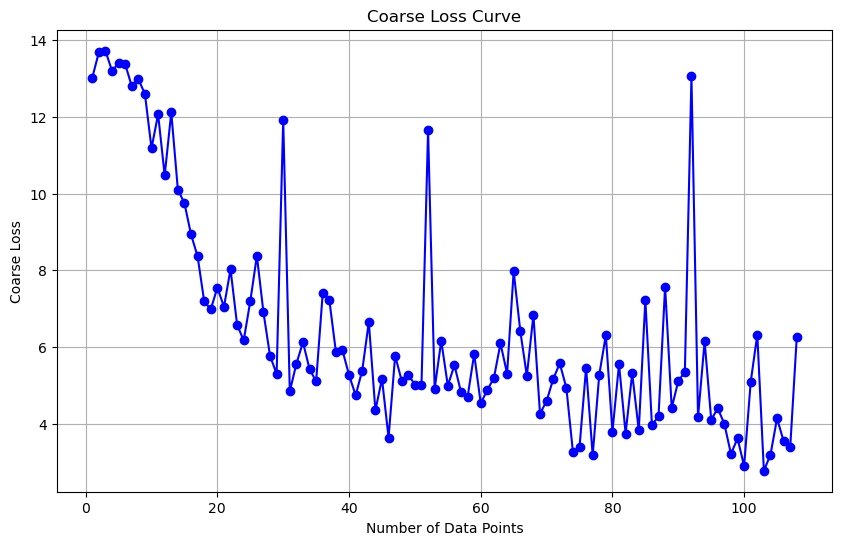

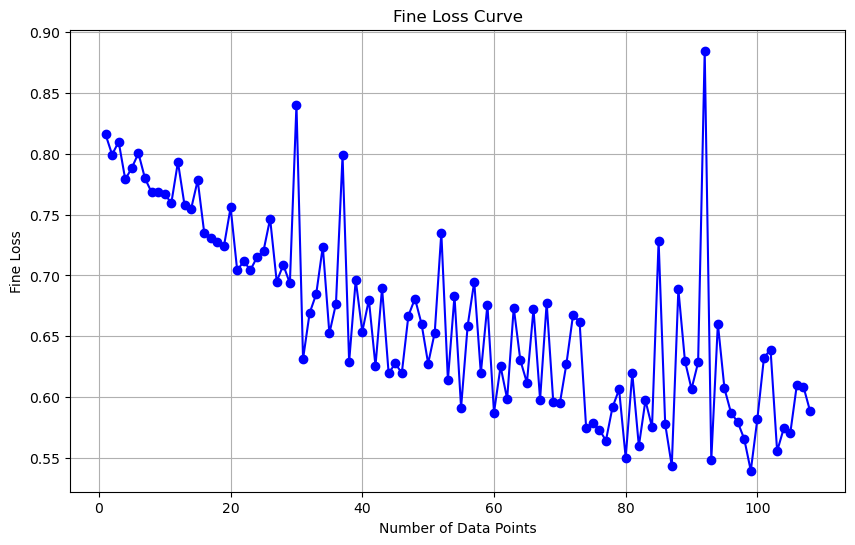

In [9]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")